### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
np.random.seed(365)
from numpy import mean
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA

import pickle
import warnings
warnings.filterwarnings("ignore")

Noting from 02.Exploratory_Data_Analysis.ipynb, we saw that after covid started, there was a massive decline in the demand for taxis. This is why we decided to use precovid cases and covid cases to forecast different boroughs.

### Read in Dataset

In [2]:
all_df = pickle.load(open('./data/final_cleaned_data/all_cleaned_data.pkl','rb'))
bronx_df = pickle.load(open('./data/final_cleaned_data/bronx_cleaned_data.pkl','rb'))
brooklyn_df = pickle.load(open('./data/final_cleaned_data/brooklyn_cleaned_data.pkl','rb'))
manhattan_df = pickle.load(open('./data/final_cleaned_data/manhattan_cleaned_data.pkl','rb'))
queens_df = pickle.load(open('./data/final_cleaned_data/queens_cleaned_data.pkl','rb'))
staten_df = pickle.load(open('./data/final_cleaned_data/staten_cleaned_data.pkl','rb'))

In [3]:
# Placeholder for RMSE scores;
placeholder_manhattan = {}
placeholder_queens = {}
placeholder_bronx = {}
placeholder_brooklyn = {}
placeholder_staten = {}


### Let's separate before lockdown and after lockdown in different boroughs due to covid.

In [4]:
# Manhattan
man_precovid_df = manhattan_df[:'2020-03-21']
#man_covid_df = manhattan_df['2020-03-22':]

#Queens
queens_precovid_df = queens_df[:'2020-03-21']
#queens_covid_df = queens_df['2020-03-21':]

# Brooklyn
brooklyn_precovid_df = brooklyn_df[:'2020-03-21']
#brooklyn_covid_df = brooklyn_df['2020-03-21':]

# Bronx
bronx_precovid_df = bronx_df[:'2020-03-21']
#bronx_covid_df = bronx_df['2020-03-21':]

# Staten Island
staten_precovid_df = staten_df[:'2020-03-21']
staten_covid_df = staten_df['2020-03-21':]

##### Splitting into train and test sets for Manhattan:

In [5]:
man_precovid_df

,count
pickup_time,
2019-06-01 00:00:00,10744
2019-06-01 01:00:00,8371
2019-06-01 02:00:00,6212
2019-06-01 03:00:00,4319
2019-06-01 04:00:00,2921
...,...
2020-03-21 19:00:00,709
2020-03-21 20:00:00,539
2020-03-21 21:00:00,386


In [6]:
## PRECOVID TRAIN(70%), TEST SET(30%)
#X = man_precovid_df.values
#size = int(len(X) * 0.70)

size='2020-02-01'
man_precovid_train, man_precovid_test  = man_precovid_df[:size], man_precovid_df[size:]
queens_precovid_train, queens_precovid_test  = queens_precovid_df[:size], queens_precovid_df[size:]
brooklyn_precovid_train, brooklyn_precovid_test  = brooklyn_precovid_df[:size], brooklyn_precovid_df[size:]
bronx_precovid_train, bronx_precovid_test  = bronx_precovid_df[:size], bronx_precovid_df[size:]
staten_precovid_train, staten_precovid_test  = staten_precovid_df[:size], staten_precovid_df[size:]

## COVID  (70%), TEST (30%)
#man_covid_train, man_covid_test = man_covid_df[:size], man_covid_df[size:]
#queens_covid_train, queens_covid_test = queens_covid_df[:size], queens_covid_df[size:]
#brooklyn_covid_train, brooklyn_covid_test = brooklyn_covid_df[:size], brooklyn_covid_df[size:]
#bronx_covid_train, bronx_covid_test = bronx_covid_df[:size], bronx_covid_df[size:]
#staten_covid_train, staten_covid_test = staten_covid_df[:size], staten_covid_df[size:]

# PRE-COVID: MANHATTAN

### Naive Forecast: Manhattan

Forecast the net day by taking last day value and estimate same value for the next day: Assuming next expected point is equal to the last observed point


In [7]:
man_precovid_train.index

DatetimeIndex(['2019-06-01 00:00:00', '2019-06-01 01:00:00',
               '2019-06-01 02:00:00', '2019-06-01 03:00:00',
               '2019-06-01 04:00:00', '2019-06-01 05:00:00',
               '2019-06-01 06:00:00', '2019-06-01 07:00:00',
               '2019-06-01 08:00:00', '2019-06-01 09:00:00',
               ...
               '2020-02-01 14:00:00', '2020-02-01 15:00:00',
               '2020-02-01 16:00:00', '2020-02-01 17:00:00',
               '2020-02-01 18:00:00', '2020-02-01 19:00:00',
               '2020-02-01 20:00:00', '2020-02-01 21:00:00',
               '2020-02-01 22:00:00', '2020-02-01 23:00:00'],
              dtype='datetime64[ns]', name='pickup_time', length=5904, freq='H')

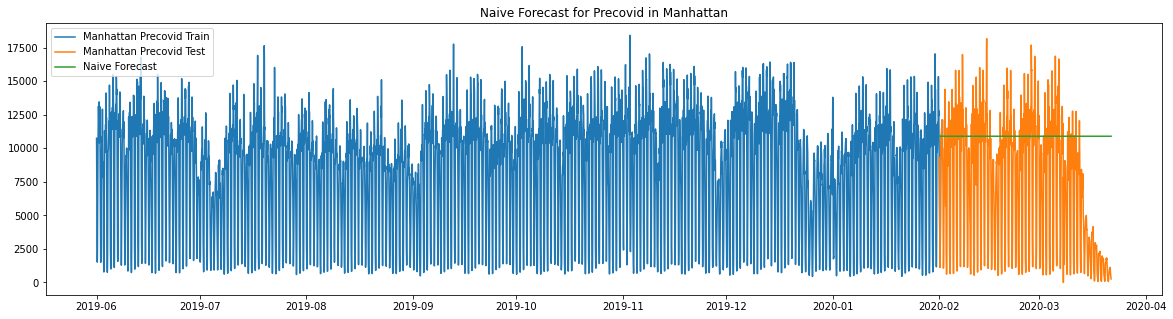

In [8]:
#dd= np.asarray(train_.count)
y_hat = man_precovid_test.copy()
y_hat['naive'] = man_precovid_train['count'][len(man_precovid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(man_precovid_train.index, man_precovid_train['count'], label='Train')
plt.plot(man_precovid_test.index,man_precovid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Manhattan Precovid Train', 'Manhattan Precovid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Precovid in Manhattan")
plt.savefig('./images/naive_precovid')
plt.show()


In [9]:
rmse_naive = math.sqrt(mean_squared_error(man_precovid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_manhattan['naive_forecast_baseline'] = rmse_naive
placeholder_manhattan

rmse_naive: 6024.486544995626


{'naive_forecast_baseline': 6024.486544995626}

Using Naive Forecasting, we got a RMSE score of 8276.80 which means that our model fits with 4805 error. Naive Forecast Model is not ideal because it's only using the last value of my train to predict on the rest 

#### Baseline: Rolling Moving Average: Manhattan

Forecast the next hour by taking the day before and estimate same value for the next hdaour: Assuming next expected point is equal to the last observed point

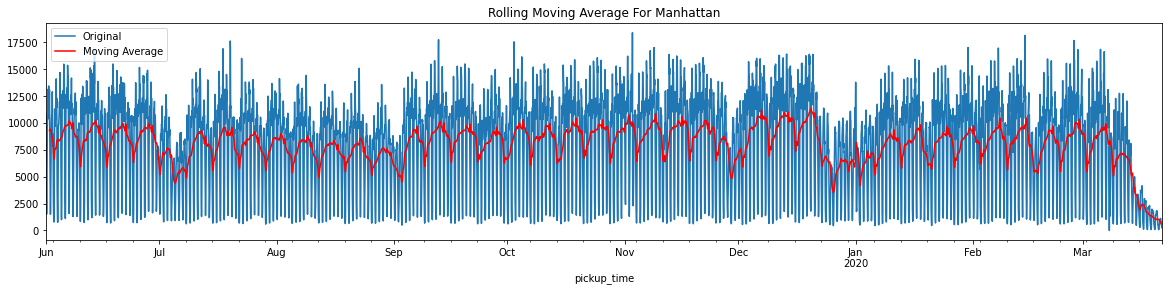

In [62]:
# Tail-rolling average transform
rolling = man_precovid_df.rolling(window=24)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
man_precovid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Manhattan')
plt.show()

In [63]:
series = man_precovid_df
# prepare situation
X = series.values
window = 24
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)



In [64]:
print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')


Test MSE: 16510376.8547995, RMSE:4063.296304086068


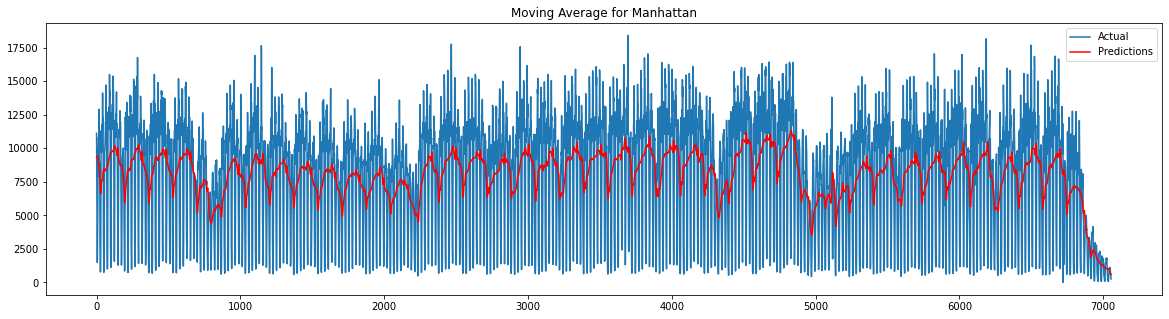

In [65]:
fig, ax =  plt.subplots(figsize=(20,5))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title('Moving Average for Manhattan')
plt.legend(['Actual', 'Predictions'])
plt.show()

It's not very clear from the graph above so let's look at the zoomed graph of first 100 hours

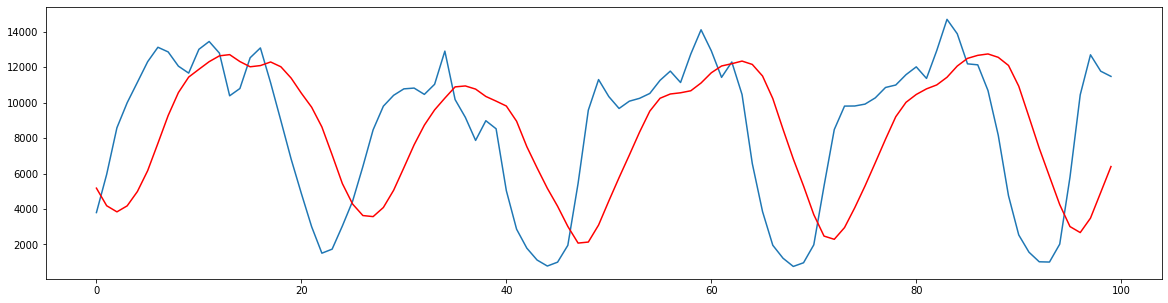

In [14]:
fig, ax =  plt.subplots(figsize=(20,5))
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red') #first 100th hour
plt.show()

Looking at the first 100 hour,  we can see there is some lag. 

I will instantiate the placeholder object to keep all the RMSE into one place

In [15]:
placeholder_manhattan['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_manhattan

{'naive_forecast_baseline': 6024.486544995626,
 'moving_average_baseline': 4131.2698664755535}

### Holt's Linear Trend Method: Manhattan

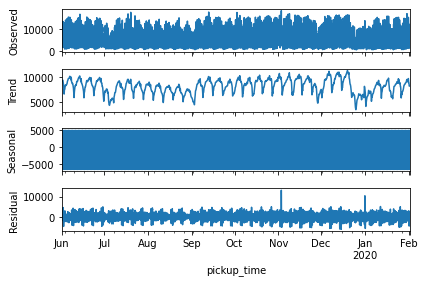

In [16]:
sm.tsa.seasonal_decompose(man_precovid_train['count']).plot()
result = sm.tsa.stattools.adfuller(man_precovid_train['count'])

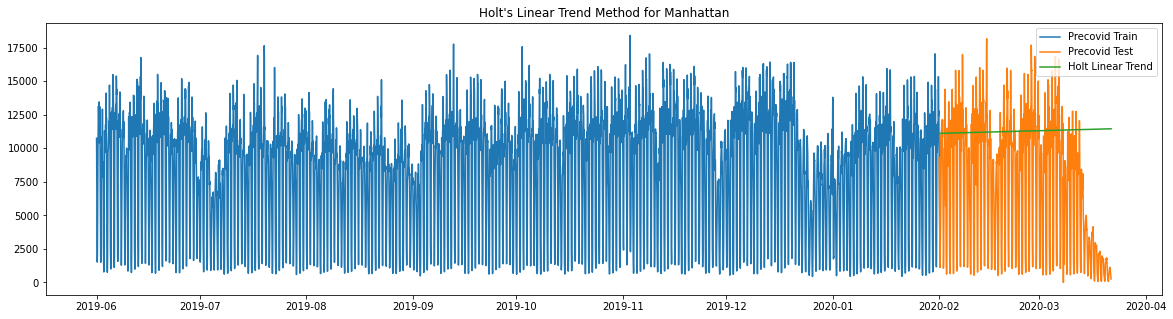

In [17]:
y_hat_avg = man_precovid_test.copy()

fit1 = Holt(np.asarray(man_precovid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.000005)
y_hat_avg['Holt_linear'] = fit1.forecast(len(man_precovid_test))

plt.figure(figsize=(20,5))
plt.plot(man_precovid_train['count'], label='Train')
plt.plot(man_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Manhattan')
plt.show()

In [18]:
rmse_holt_linear = np.sqrt(np.mean(fit1.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_manhattan['rmse_holt_linear'] = rmse_holt_linear

Holt Linear RMSE:  2036.5722509949862


In [19]:
placeholder_manhattan

{'naive_forecast_baseline': 6024.486544995626,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2036.5722509949862}

### Holt Winter Model: Manhattan

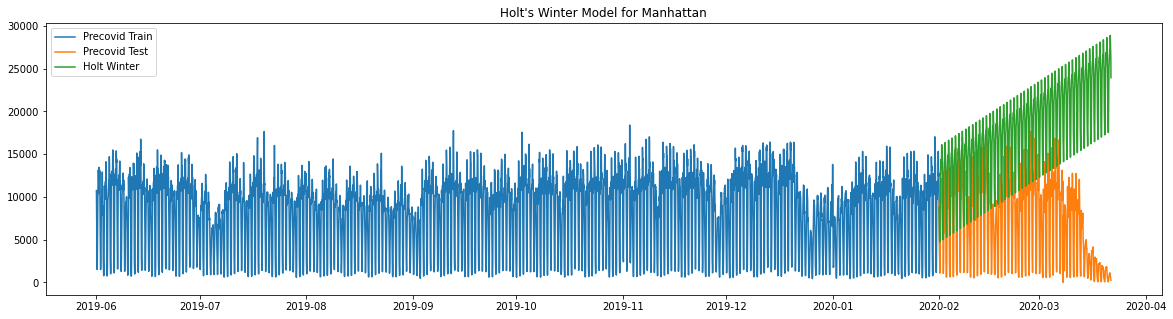

In [20]:
y_hat_avg = man_precovid_test.copy()
fit1 = ExponentialSmoothing(np.asarray(man_precovid_train['count']) ,seasonal_periods=24 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(man_precovid_test))
plt.figure(figsize=(20,5))
plt.plot(man_precovid_train['count'], label='Train')
plt.plot(man_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Manhattan')
plt.show()

In [21]:
rmse_holt_winter= np.sqrt(np.mean(fit1.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_manhattan['rmse_holt_winter'] = rmse_holt_winter
placeholder_manhattan

Holt Winter RMSE:  987.1542055166258


{'naive_forecast_baseline': 6024.486544995626,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2036.5722509949862,
 'rmse_holt_winter': 987.1542055166258}

In [22]:
placeholder_manhattan

{'naive_forecast_baseline': 6024.486544995626,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2036.5722509949862,
 'rmse_holt_winter': 987.1542055166258}

# Precovid: Queens

### Naive Forecast: Queens

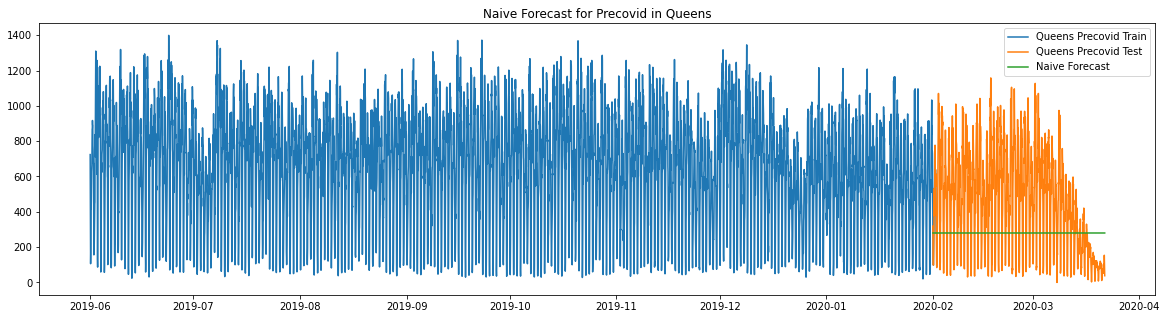

280

In [23]:
#dd= np.asarray(train_.count)
y_hat = queens_precovid_test.copy()
y_hat['naive'] = queens_precovid_train['count'][len(queens_precovid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(queens_precovid_train.index, queens_precovid_train['count'], label='Train')
plt.plot(queens_precovid_test.index,queens_precovid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Queens Precovid Train', 'Queens Precovid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Precovid in Queens")
plt.show()
queens_precovid_train['count'][len(queens_precovid_train['count'])-1]

In [24]:
rmse_naive = math.sqrt(mean_squared_error(queens_precovid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_queens['naive_forecast_baseline'] = rmse_naive
placeholder_queens

rmse_naive: 338.6777905817465


{'naive_forecast_baseline': 338.6777905817465}

### Rolling Mean Average: Queens

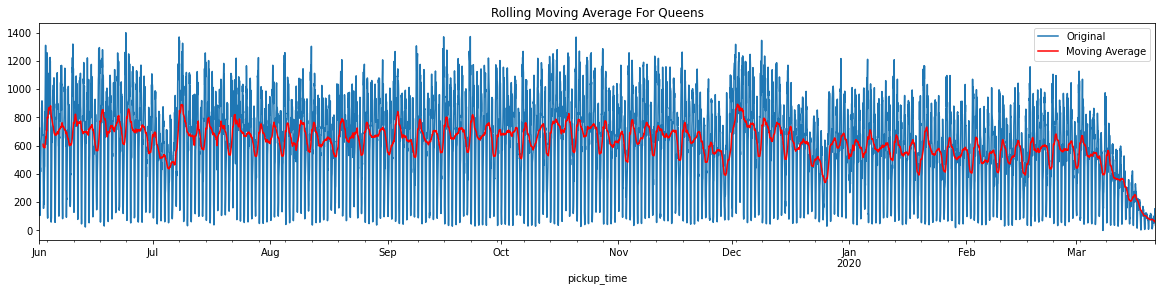

In [25]:
# Tail-rolling average transform
rolling = queens_precovid_df.rolling(window=24)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
queens_precovid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Queens')
plt.show()

In [26]:
series = queens_precovid_df
# prepare situation
X = series.values
window = 7
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)

print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')
placeholder_queens['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_queens

Test MSE: 88322.66573084767, RMSE:297.19129484365396


{'naive_forecast_baseline': 338.6777905817465,
 'moving_average_baseline': 297.19129484365396}

## Holt Linear Trend Method: Queens

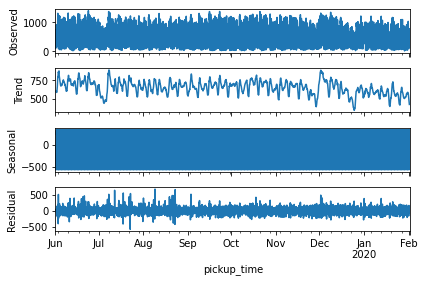

In [27]:
sm.tsa.seasonal_decompose(queens_precovid_train['count']).plot()
result = sm.tsa.stattools.adfuller(queens_precovid_train['count'])

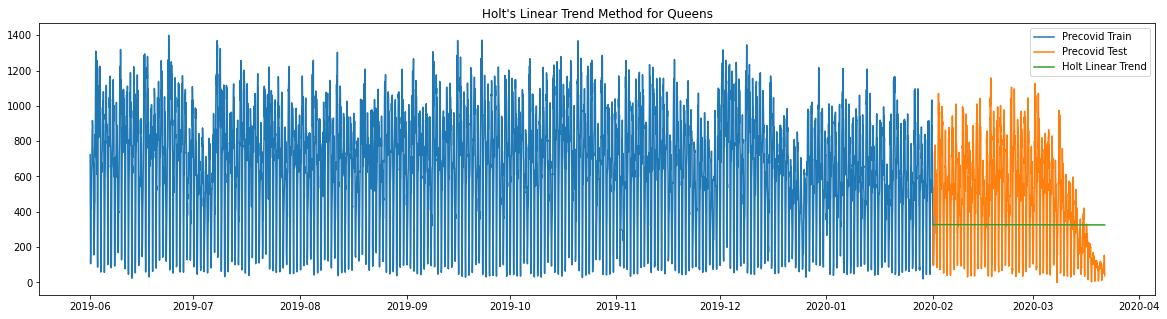

In [28]:
y_hat_avg = queens_precovid_test.copy()

fit_queens = Holt(np.asarray(queens_precovid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.000005)
y_hat_avg['Holt_linear'] = fit_queens.forecast(len(queens_precovid_test))

plt.figure(figsize=(20,5))
plt.plot(queens_precovid_train['count'], label='Train')
plt.plot(queens_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Queens')
plt.show()

In [29]:
rmse_holt_linear = np.sqrt(np.mean(fit_queens.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_queens['rmse_holt_linear'] = rmse_holt_linear
placeholder_queens

Holt Linear RMSE:  165.21037053916072


{'naive_forecast_baseline': 338.6777905817465,
 'moving_average_baseline': 297.19129484365396,
 'rmse_holt_linear': 165.21037053916072}

## Holt Winter Method: Queens

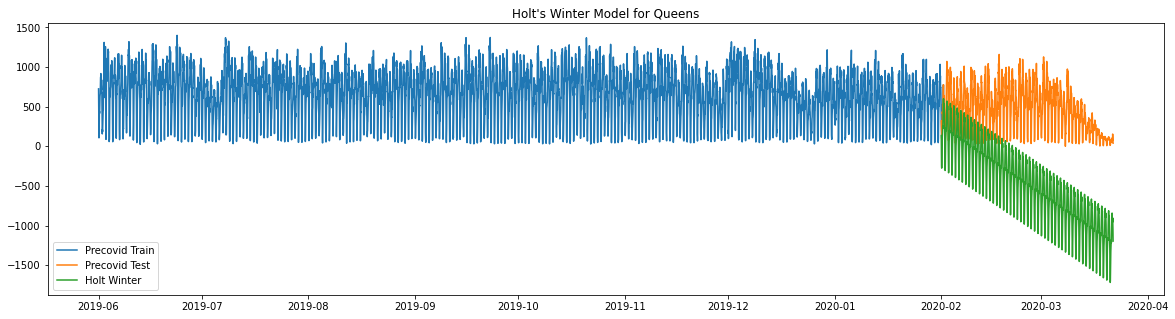

In [30]:
y_hat_avg = queens_precovid_test.copy()
fit_winter_queens = ExponentialSmoothing(np.asarray(queens_precovid_train['count']) ,seasonal_periods=24,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_winter_queens.forecast(len(queens_precovid_test))
plt.figure(figsize=(20,5))
plt.plot(queens_precovid_train['count'], label='Train')
plt.plot(queens_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Queens')
plt.show()

In [31]:
rmse_holt_winter= np.sqrt(np.mean(fit_winter_queens.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_queens['rmse_holt_winter'] = rmse_holt_winter
placeholder_queens

Holt Winter RMSE:  94.7944067110398


{'naive_forecast_baseline': 338.6777905817465,
 'moving_average_baseline': 297.19129484365396,
 'rmse_holt_linear': 165.21037053916072,
 'rmse_holt_winter': 94.7944067110398}

Compared to Manhattan, there are less pickups overall but the graphs do look similar. You can see that overall, Holt Winter Model does best so far. 

# Precovid: Brooklyn

### Naive Forecast: Brooklyn

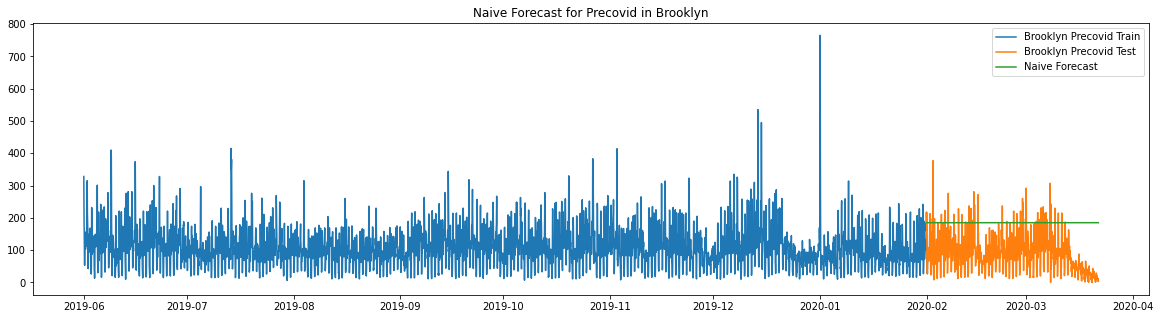

In [32]:
#dd= np.asarray(train_.count)
y_hat = brooklyn_precovid_test.copy()
y_hat['naive'] = brooklyn_precovid_train['count'][len(brooklyn_precovid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(brooklyn_precovid_train.index, brooklyn_precovid_train['count'], label='Train')
plt.plot(brooklyn_precovid_test.index,brooklyn_precovid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Brooklyn Precovid Train', 'Brooklyn Precovid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Precovid in Brooklyn")
plt.show()

In [33]:
rmse_naive = math.sqrt(mean_squared_error(brooklyn_precovid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_brooklyn['naive_forecast_baseline'] = rmse_naive
placeholder_brooklyn

rmse_naive: 110.50189289479766


{'naive_forecast_baseline': 110.50189289479766}

#### Rolling Mean Averages: Brooklyn

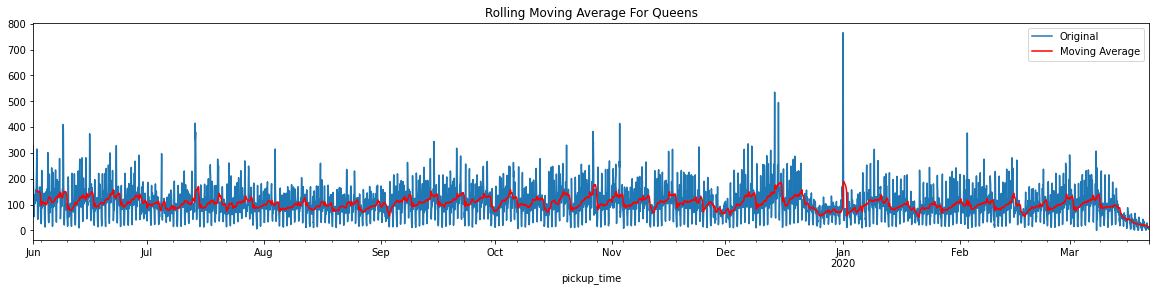

In [34]:
# Tail-rolling average transform
rolling = brooklyn_precovid_df.rolling(window=24)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
brooklyn_precovid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Queens')
plt.show()

In [35]:
series = brooklyn_precovid_df
# prepare situation
X = series.values
window = 7
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)

print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')
placeholder_brooklyn['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_brooklyn

Test MSE: 3411.856107012294, RMSE:58.411095752539126


{'naive_forecast_baseline': 110.50189289479766,
 'moving_average_baseline': 58.411095752539126}

### Holt Linear Method: Brooklyn

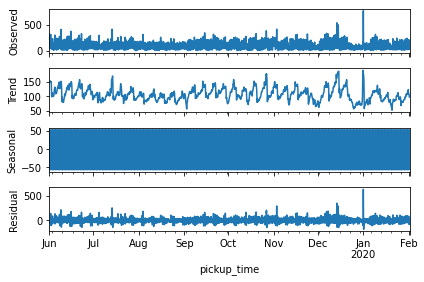

In [36]:
sm.tsa.seasonal_decompose(brooklyn_precovid_train['count']).plot()
result = sm.tsa.stattools.adfuller(brooklyn_precovid_train['count'])

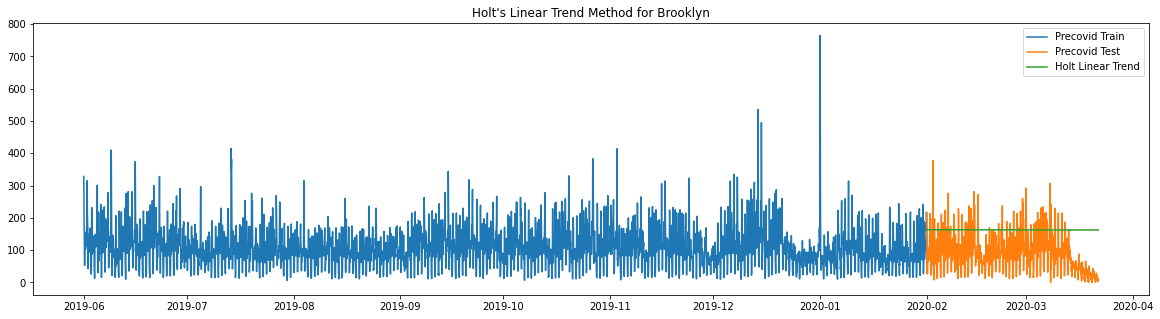

In [37]:
y_hat_avg = brooklyn_precovid_test.copy()

fit_brooklyn = Holt(np.asarray(brooklyn_precovid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.000005)
y_hat_avg['Holt_linear'] = fit_brooklyn.forecast(len(brooklyn_precovid_test))

plt.figure(figsize=(20,5))
plt.plot(brooklyn_precovid_train['count'], label='Train')
plt.plot(brooklyn_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Brooklyn')
plt.show()

In [38]:
rmse_holt_linear = np.sqrt(np.mean(fit_brooklyn.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_brooklyn['rmse_holt_linear'] = rmse_holt_linear
placeholder_brooklyn

Holt Linear RMSE:  41.18241565129823


{'naive_forecast_baseline': 110.50189289479766,
 'moving_average_baseline': 58.411095752539126,
 'rmse_holt_linear': 41.18241565129823}

#### Holt Winter Method: Brooklyn

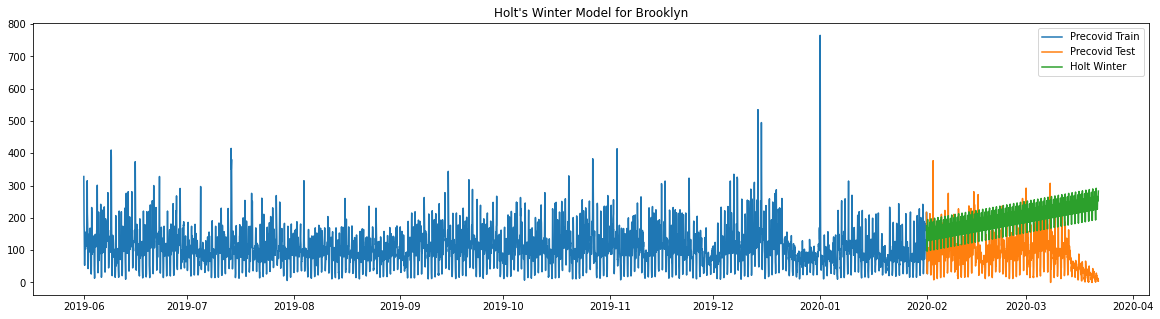

In [39]:
y_hat_avg = brooklyn_precovid_test.copy()
fit_winter_brooklyn = ExponentialSmoothing(np.asarray(brooklyn_precovid_train['count']) ,seasonal_periods=24,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_winter_brooklyn.forecast(len(brooklyn_precovid_test))
plt.figure(figsize=(20,5))
plt.plot(brooklyn_precovid_train['count'], label='Train')
plt.plot(brooklyn_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Brooklyn')
plt.show()

In [40]:
rmse_holt_winter= np.sqrt(np.mean(fit_winter_brooklyn.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_brooklyn['rmse_holt_winter'] = rmse_holt_winter
placeholder_brooklyn

Holt Winter RMSE:  30.750116436190215


{'naive_forecast_baseline': 110.50189289479766,
 'moving_average_baseline': 58.411095752539126,
 'rmse_holt_linear': 41.18241565129823,
 'rmse_holt_winter': 30.750116436190215}

## Precovid: Bronx

#### Naive Forecast: Bronx

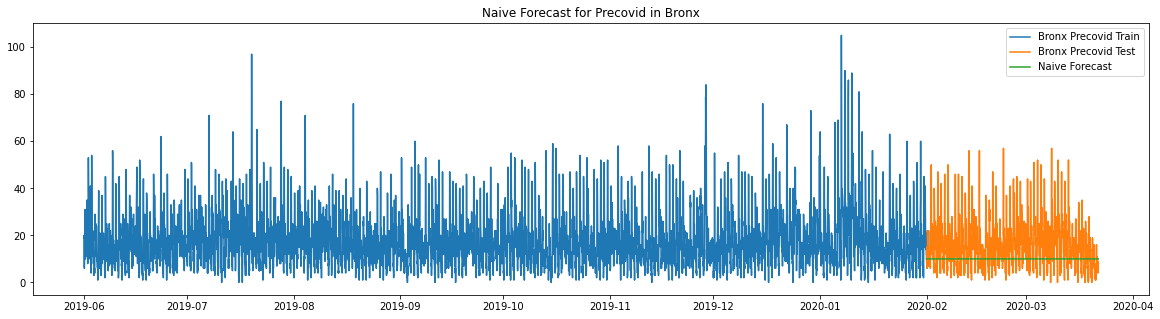

10

In [41]:
#dd= np.asarray(train_.count)
y_hat = bronx_precovid_test.copy()
y_hat['naive'] = bronx_precovid_train['count'][len(bronx_precovid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(bronx_precovid_train.index, bronx_precovid_train['count'], label='Train')
plt.plot(bronx_precovid_test.index,bronx_precovid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Bronx Precovid Train', 'Bronx Precovid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Precovid in Bronx")
plt.show()
bronx_precovid_train['count'][len(bronx_precovid_train['count'])-1]

In [42]:
rmse_naive = math.sqrt(mean_squared_error(bronx_precovid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_bronx['naive_forecast_baseline'] = rmse_naive
placeholder_bronx

rmse_naive: 11.773734893114137


{'naive_forecast_baseline': 11.773734893114137}

#### Rolling Mean Average: Bronx

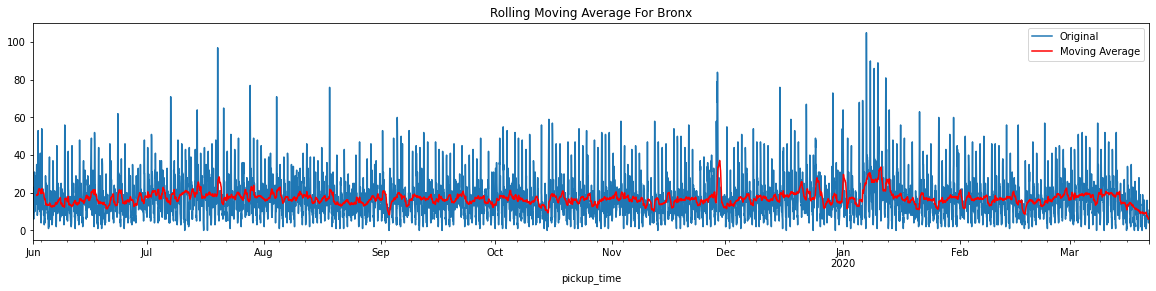

In [43]:
# Tail-rolling average transform
rolling = bronx_precovid_df.rolling(window=24)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
bronx_precovid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Bronx')
plt.show()

In [44]:
series = bronx_precovid_df
# prepare situation
X = series.values
window = 24
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)

print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')
placeholder_bronx['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_bronx

Test MSE: 117.53757957175925, RMSE:10.841474972150204


{'naive_forecast_baseline': 11.773734893114137,
 'moving_average_baseline': 10.841474972150204}

#### Holt Linear Method: Bronx

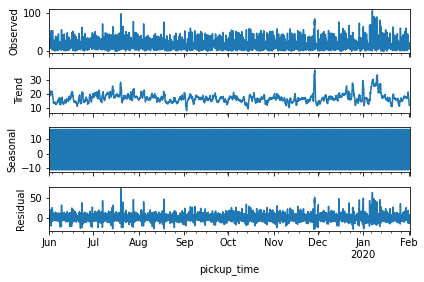

In [45]:
sm.tsa.seasonal_decompose(bronx_precovid_train['count']).plot()
result = sm.tsa.stattools.adfuller(bronx_precovid_train['count'])

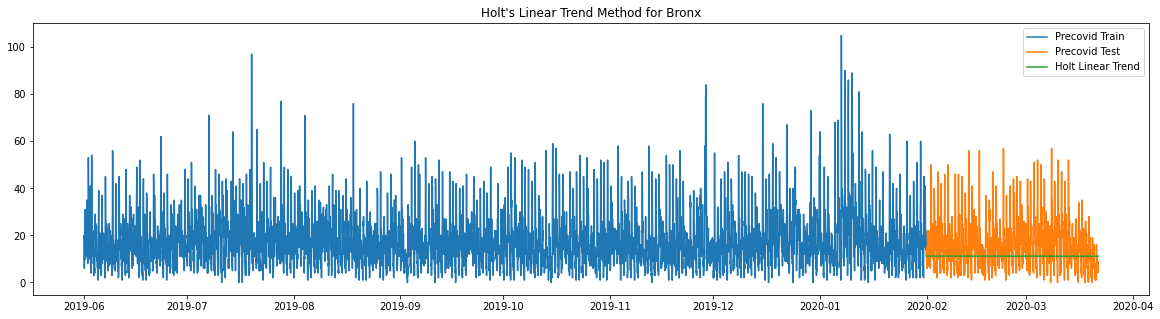

In [46]:
y_hat_avg = bronx_precovid_test.copy()

fit_bronx = Holt(np.asarray(bronx_precovid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.000005)
y_hat_avg['Holt_linear'] = fit_bronx.forecast(len(bronx_precovid_test))

plt.figure(figsize=(20,5))
plt.plot(bronx_precovid_train['count'], label='Train')
plt.plot(bronx_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Bronx')
plt.show()

In [47]:
rmse_holt_linear = np.sqrt(np.mean(fit_bronx.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_bronx['rmse_holt_linear'] = rmse_holt_linear
placeholder_bronx

Holt Linear RMSE:  8.94364141967824


{'naive_forecast_baseline': 11.773734893114137,
 'moving_average_baseline': 10.841474972150204,
 'rmse_holt_linear': 8.94364141967824}

#### Holt Winter Method: Bronx

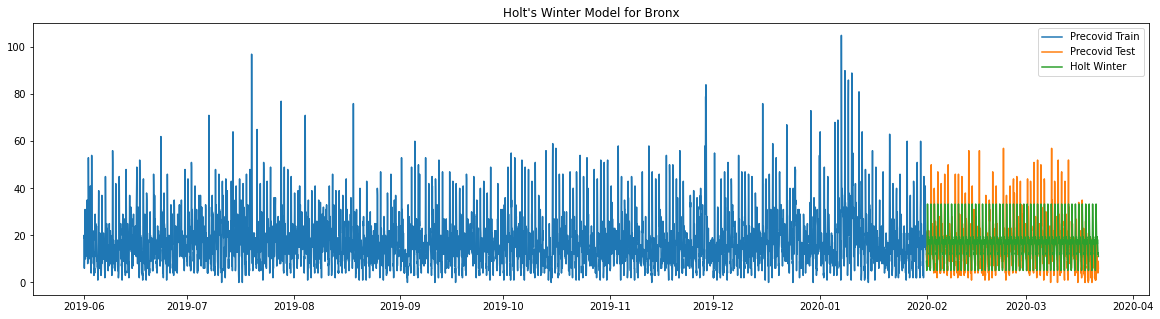

In [48]:
y_hat_avg = bronx_precovid_test.copy()
fit_winter_bronx = ExponentialSmoothing(np.asarray(bronx_precovid_train['count']) ,seasonal_periods=24,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_winter_bronx.forecast(len(bronx_precovid_test))
plt.figure(figsize=(20,5))
plt.plot(bronx_precovid_train['count'], label='Train')
plt.plot(bronx_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Bronx')
plt.show()

In [49]:
rmse_holt_winter= np.sqrt(np.mean(fit_winter_bronx.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_bronx['rmse_holt_winter'] = rmse_holt_winter
placeholder_bronx

Holt Winter RMSE:  7.6352757342102695


{'naive_forecast_baseline': 11.773734893114137,
 'moving_average_baseline': 10.841474972150204,
 'rmse_holt_linear': 8.94364141967824,
 'rmse_holt_winter': 7.6352757342102695}

## Precovid: Staten Island

#### Naive Forecast: Staten Island

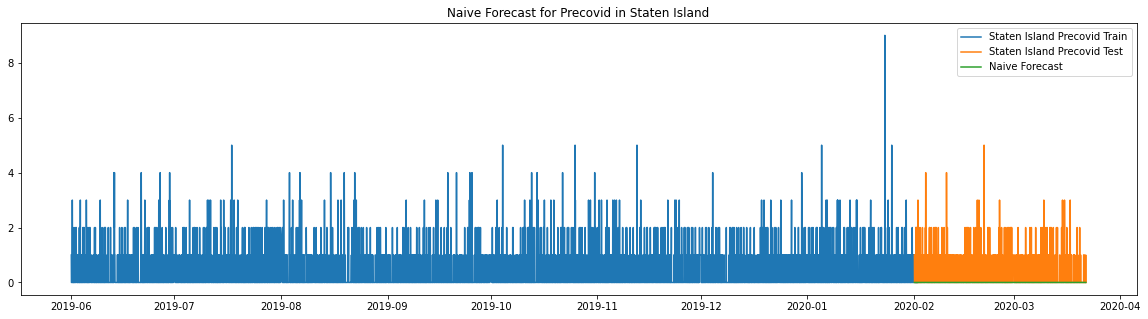

0

In [50]:
#dd= np.asarray(train_.count)
y_hat = staten_precovid_test.copy()
y_hat['naive'] = staten_precovid_train['count'][len(staten_precovid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(staten_precovid_train.index, staten_precovid_train['count'], label='Train')
plt.plot(staten_precovid_test.index,staten_precovid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Staten Island Precovid Train', 'Staten Island Precovid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Precovid in Staten Island")
plt.show()
staten_precovid_train['count'][len(staten_precovid_train['count'])-1]

In [51]:
rmse_naive = math.sqrt(mean_squared_error(staten_precovid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_staten['naive_forecast_baseline'] = rmse_naive
placeholder_staten

rmse_naive: 0.7279127850973344


{'naive_forecast_baseline': 0.7279127850973344}

#### Rolling Mean Average: Staten Island

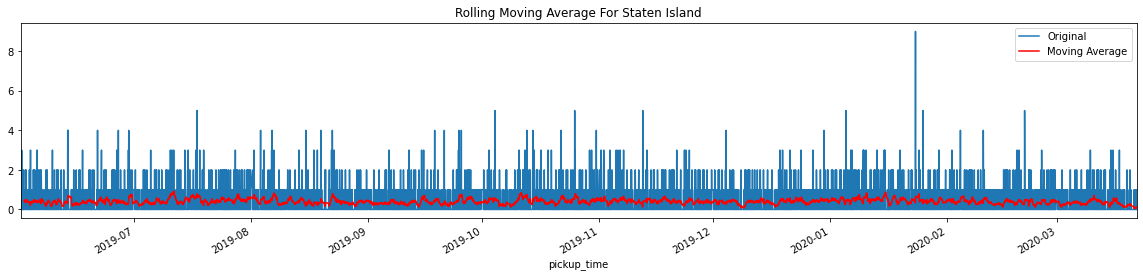

In [52]:
# Tail-rolling average transform
rolling = staten_precovid_df.rolling(window=24)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
staten_precovid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Staten Island')
plt.show()

In [53]:
series = staten_precovid_df
# prepare situation
X = series.values
window = 24
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)

print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')
placeholder_staten['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_staten

Test MSE: 0.5111732675626727, RMSE:0.7149638225551505


{'naive_forecast_baseline': 0.7279127850973344,
 'moving_average_baseline': 0.7149638225551505}

#### Holt Linear Method: Staten Island

In [54]:
staten_precovid_train

,count
pickup_time,
2019-06-01 02:00:00,1
2019-06-01 03:00:00,0
2019-06-01 04:00:00,0
2019-06-01 05:00:00,0
2019-06-01 06:00:00,0
...,...
2020-02-01 19:00:00,0
2020-02-01 20:00:00,0
2020-02-01 21:00:00,1


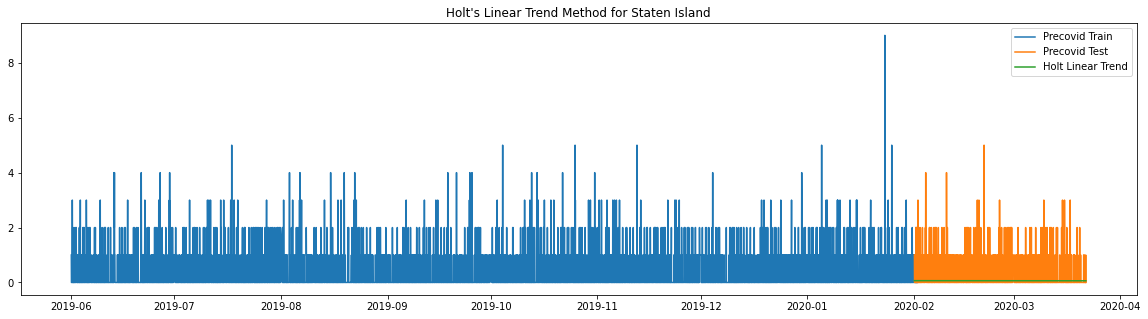

In [55]:
y_hat_avg = staten_precovid_test.copy()

fit_staten = Holt(np.asarray(staten_precovid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.000005)
y_hat_avg['Holt_linear'] = fit_staten.forecast(len(staten_precovid_test))

plt.figure(figsize=(20,5))
plt.plot(staten_precovid_train['count'], label='Train')
plt.plot(staten_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Staten Island')
plt.show()

In [56]:
rmse_holt_linear = np.sqrt(np.mean(fit_staten.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_staten['rmse_holt_linear'] = rmse_holt_linear
placeholder_staten

Holt Linear RMSE:  0.8640936117151591


{'naive_forecast_baseline': 0.7279127850973344,
 'moving_average_baseline': 0.7149638225551505,
 'rmse_holt_linear': 0.8640936117151591}

#### Holt Winter Method: Staten Island

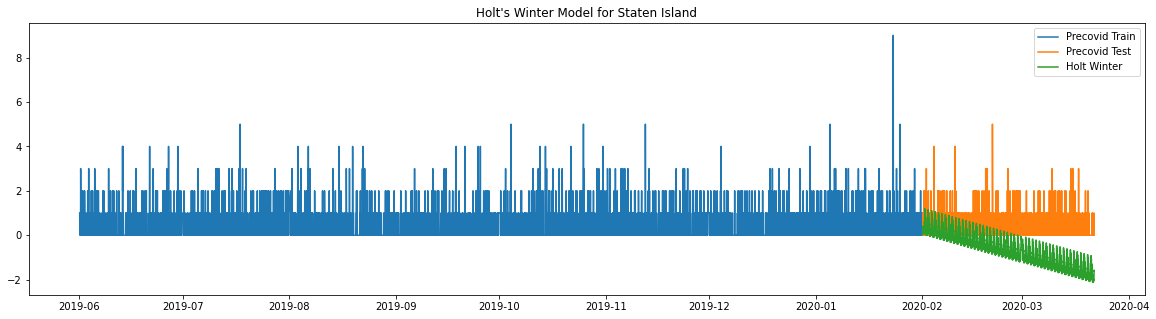

In [57]:
y_hat_avg = staten_precovid_test.copy()
fit_winter_staten = ExponentialSmoothing(np.asarray(staten_precovid_train['count']) ,seasonal_periods=24,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_winter_staten.forecast(len(staten_precovid_test))
plt.figure(figsize=(20,5))
plt.plot(staten_precovid_train['count'], label='Train')
plt.plot(staten_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Staten Island')
plt.show()

In [58]:
rmse_holt_winter= np.sqrt(np.mean(fit_winter_staten.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_staten['rmse_holt_winter'] = rmse_holt_winter
placeholder_staten

Holt Winter RMSE:  0.7352204546402626


{'naive_forecast_baseline': 0.7279127850973344,
 'moving_average_baseline': 0.7149638225551505,
 'rmse_holt_linear': 0.8640936117151591,
 'rmse_holt_winter': 0.7352204546402626}

In [59]:
pickle.dump(placeholder_manhattan, open(f'./data/pickled/placeholder_manhattan.pkl','wb'))
pickle.dump(placeholder_queens, open(f'./data/pickled/placeholder_queens.pkl','wb'))
pickle.dump(placeholder_bronx, open(f'./data/pickled/placeholder_bronx.pkl','wb'))
pickle.dump(placeholder_brooklyn, open(f'./data/pickled/placeholder_brooklyn.pkl','wb'))
pickle.dump(placeholder_staten, open(f'./data/pickled/placeholder_staten.pkl','wb'))

